**Gibbs sampling on a bivariate Gaussian**

In this code, we are going to show how to generate samples from a bivariate Gaussian distribution using a Gibbs sampler. If you have any questions, you can contact the instructor.

The first thing we need to do is to import the necessary libraries. We will use numpy to generate the samples, and scipy and matplotlib to plot the results. We will also use the magic command `%matplotlib inline` to show the plots in the notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import interpolate
from scipy.stats import multivariate_normal

In the next cell, we implement an ancillary method to get the contour plot of the bivariate Gaussian. This method is not necessary to understand the code, but it is useful to plot the results and see that the data points are indeed generated from the distribution we want. In short, what we are doing are obtaining the curves of the bivariate Gaussian that enclose a certain percentage of the probability. For example, the 95% confidence interval is the curve that encloses 95% of the probability over the range of the random variable. We will use this method later to plot the results.

In [6]:
# Ancillary method, used for plotting the 95% confidence interval later
def get_elipse(covar, mean):
    eigenval, eigenvec = np.linalg.eig(covar)
    # Get the largest and smalles eigenvalue and eigenvector
    largest_eigenvec = eigenvec[:, np.argmax(eigenval)]
    largest_eigenval = np.amax(eigenval)
    smallest_eigenvec = eigenvec[:, np.argmin(eigenval)]
    smallest_eigenval = np.amin(eigenval)
    angle = np.arctan2(largest_eigenvec[1], largest_eigenvec[0])
    if angle < 0:
        angle += 2 * np.pi  # So that the angle is between 0 and 2 * pi

    chisquare_val = 2.4477  # For the 95% confidence interval
    theta_grid = np.linspace(0, 2 * np.pi)
    phi = angle
    X0 = mean[0]
    Y0 = mean[1]
    a = chisquare_val * np.sqrt(largest_eigenval)
    b = chisquare_val * np.sqrt(smallest_eigenval)

    ellipse_x = np.vstack([a * np.cos(theta_grid), b * np.sin(theta_grid)]).T

    R = np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)]])

    r_ellipse = ellipse_x @ R

    return r_ellipse, X0, Y0

Let us now define the parameters of the bivariate Gaussian distribution, which are five: the variances of the two coordinates, the correlation coefficient, and the mean of each coordinate. In vector notation, we need the mean vector and the covariance matrix:

$\mu=\begin{pmatrix}
\mu_1\\
\mu_2
\end{pmatrix}, \quad C=\begin{pmatrix}
\sigma_1^2 & \rho \sigma_1 \sigma_2\\
\rho \sigma_1 \sigma_2 & \sigma_2^2
\end{pmatrix} $

In [3]:
mu=np.array([0.0, 1.0])  # Mean vector
s1 = 0.2  # Variance of the first Gaussian
s2 = 0.5  # Variance of the second Gaussian
ro = 0.7  # Correlation coefficient
C = np.array([[s1 ** 2, s1 * s2 * ro],[s1 * s2 * ro, s2 ** 2]])  # Covariance matrix

We are now ready to implement the Gibbs sampler. Remember that this sampler is based on sampling from the conditional distributions, which in case of the bivariate Gaussian are:

$p(x_1|x_2)=\mathcal{N}\left( \mu_1 + \rho \frac{\sigma_1}{\sigma_2} (x_2-\mu_2), \sigma_1^2 (1-\rho^2) \right) \\
p(x_2|x_1)=\mathcal{N}\left( \mu_2 + \rho \frac{\sigma_2}{\sigma_1} (x_1-\mu_1), \sigma_2^2 (1-\rho^2) \right) $

Note that the next code is a direct implementation of these equations, where we store the samples in the matrix `x`.

In [4]:
n_samples = 10000  # Number of samples to generate
x = np.zeros((n_samples, 2))  # Matrix to store the values
s12 = s1 ** 2 * (1 - ro ** 2)  # Auxiliary value: the variance of the first conditional
s21 = s2 ** 2 * (1 - ro ** 2)  # Auxiliary value: the variance of the second conditional
prev_value = np.array([0.0, 0.0])  # Initial value to start sampling
for i in range(n_samples):  # Gibbs method
    m12 = mu[0] + ro * s1 / s2 * (prev_value[1] - mu[1])
    prev_value[0] = np.random.randn(1) * np.sqrt(s12) + m12
    m21 = mu[1] + ro * s2 / s1 * prev_value[0] - mu[0]
    prev_value[1] = np.random.randn(1) * np.sqrt(s21) + m21
    x[i, :] = prev_value  # Save the new sample obtained

Finally, we plot the results. We will plot the contour of the bivariate Gaussian, and the samples obtained from the Gibbs sampler. Note that the samples are indeed generated from the distribution, as they are inside the contour (which contains the samples generated with a probability of 95%).

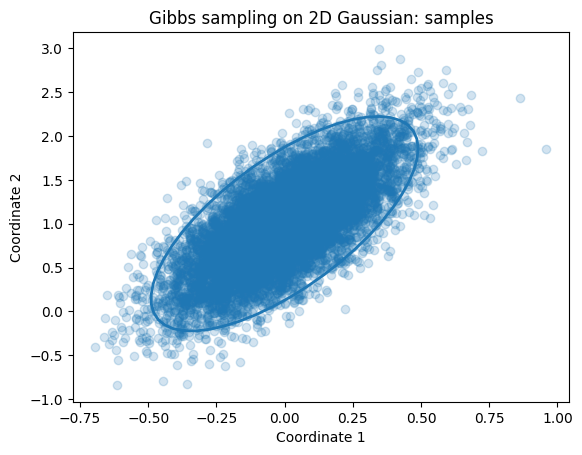

In [5]:
x_min = mu[0] - 3 * s1
x_max = mu[0] + 3 * s1
y_min = mu[1] - 3 * s2
y_max = mu[1] + 3 * s2
r_ellipse, X0, Y0 = get_elipse(C, mu)
plt.plot(r_ellipse[:, 0] + X0, r_ellipse[:, 1] + Y0, linewidth=2)
plt.scatter(x[:, 0], x[:, 1], alpha=0.2)
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.title('Gibbs sampling on 2D Gaussian: samples')
plt.show()
